# Utilisation du modèle fondation SAM

Un modèle fondation est un modèle généraliste, pré appris sur des données variées et permettant d'intégrer l'ensemble des représentations utiles pour les images. 

Le but de ces modèles est de mettre à disposition des modèles appris peu spécifiques mais permettant de profiter des puissances d'apprentissage non disponibles de manière personnelle. 

Dans ce document, nous allons tester le modèle de segmentation fourni par Meta, maison mère de Facebook, appelé Segment Anything Model (SAM).

N'hésitez pas à tester par vous même la puissance de ce genre de modèle :
 * [lien]() 
 * [exemples]()

Le but ultime de ces modèles est d'être affiné sur des problématiques spécifiques. Mais pour cela, il nous faut des données et de la puissance de calcul.

## Chargement du modèle

1. Dans un premier temps, nous allons utiliser la bibliothèque fournir par Meta. La première ligne permet de charger les fonctions utiles pour le chargement.

2. La deuxième ligne permet de charger les poids du réseau (ce qui a été appris et fourni par Meta) et les intégrer dans notre modèle. Ces poids constituent les paramètres du modèle, et ont été optimisés en utilisant un grand nombre de données. 

3. Enfin, la derniere ligne nous permet de créer un modele de segmentation, que l'on va pouvoir appliquer sur des images.

In [1]:

import matplotlib.pyplot as plt

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="./assets/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)

## Chargement d'une image

Afin de pouvoir évaluer qualitativement notre modèle fondation, nous allons charger une image à segmenter. Renseignez le dossier et l'image que vous souhaitez tester. 

Dans cet atelier, nous allons nous focaliser sur des images en niveaux de gris, où chaque pixel est associé à une valeur, au lieu de trois dans le cas d'images couleurs.  

In [8]:
import os
import cv2
import numpy as np

# Dossier dans lequel se trouve les images.
tiff_folder = './images_raw/CEA2_MEB'
# Image à tester
image = "Image_4_01.tif"
image_path = os.path.join(tiff_folder, image)

# On convertit l'image en niveaux de gris. 
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)


Affichons maintenant l'image, grâce à la bibliothèque `matplotlib`

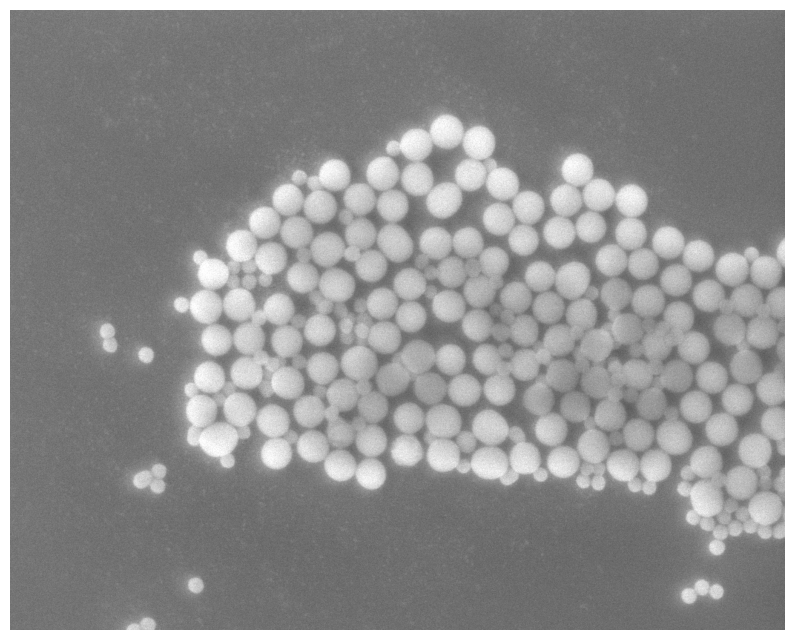

In [9]:

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


## Segmentation 

Une fois le modèle chargé, la segmentation est triviale d'un point de vue du code utilisé, merci la bibliothèque !

Attention toutefois, le modèle étant très lourd, la segmentation peut durer plusieurs minutes sur des machines modestes, sans unité de calcul dédiées.

In [10]:
# La ligne de code qui segmente !
masks = mask_generator.generate(image)

Maintenant, jetons un oeil au résultat de notre segmentation. La variable `masks` contient un ensemble de zones homogènes correspondant aux régions segmentées. Par exemple, en regardant la longueur de la séquence on peut connaitre le nombre de régions identifiées. 

Pour chaque région, nous avons la carte de la région considérée dans la clé `segmentation`

Nombre de régions détectées : 205


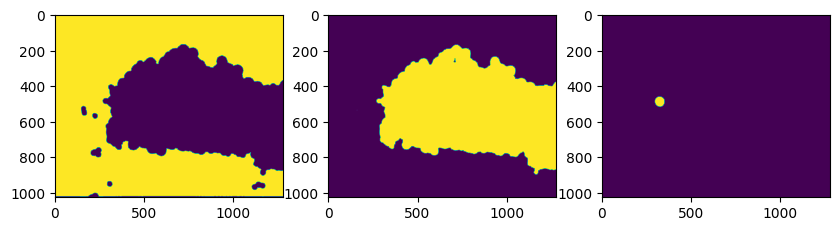

In [25]:
nb_regions = len(masks)
print(f"Nombre de régions détectées : {nb_regions}")

fig, ax = plt.subplots(1,3, figsize=(10,3))
# La premiere région est le fond 
ax[0].imshow(masks[0]['segmentation'])
# La deuxieme région est le fond 
ax[1].imshow(masks[1]['segmentation'])

# Affichez une région de votre choix  
ax[2].imshow(masks[2]['segmentation'])


Afin d'avoir un affichage plus complet, nous avons implémetés deux fonctions permettant soit de représenter l'ensemble des régions (`show_anns`) ou alors les contours de l'ensemble des régions (̀`show_contours_yellow`). 

In [33]:
def show_regions(masks):
    """
    Affiche chaque région présente dans masks avec une couleur différente 
    """
    if len(masks) == 0:
        return
    sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_contours(masks):
    """
    Dessine les contours de chaque région présente dans masks en rouge 
    """
    if len(masks) == 0:
        return
    sorted_anns = sorted(masks, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img, contours, -1, (255, 255, 0, 0.35), 2)  # Draw contours in yellow
    ax.imshow(img)



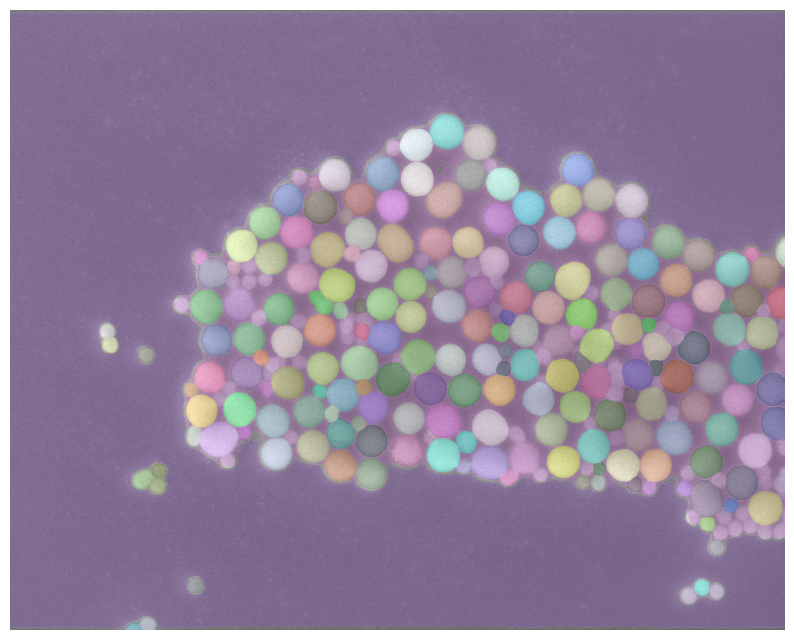

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
show_regions(masks)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


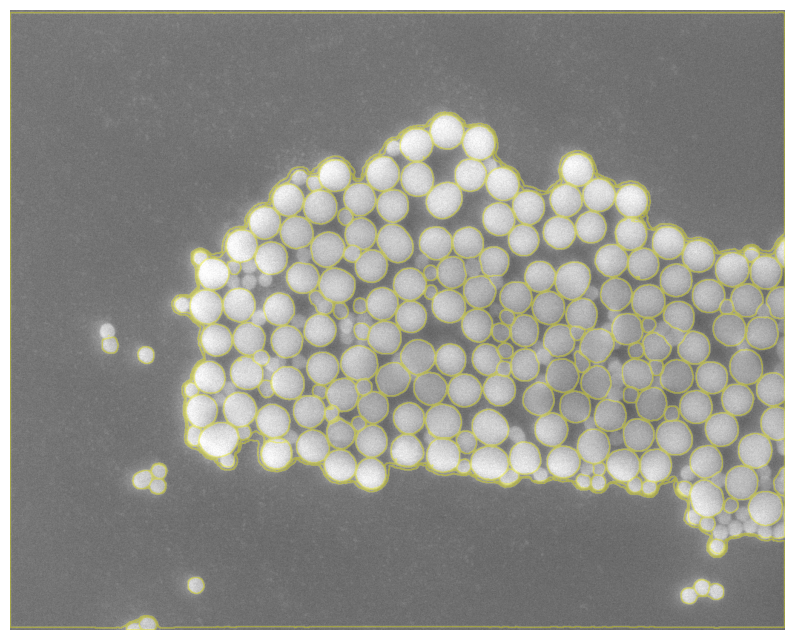

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
show_contours(masks)
plt.show()


Voilà, vous avez utilisé un modèle fondation, félicitations. Si vous souhaitez aller plus loin : 
 - Tester d'autres images, et essayer de challenger le modèle. Il n'est pas parfait !
 - Surveiller l'apparation de nouveaux poids, et testez les en lieu et place de la configuration actuelle.
  - Tester SAM v2 !